# Plots after photoreceptor quantification in Napari.ipynb
***

***
## Load modules<a id='loadModules'>∮</a>
***
Back to [Index](#Index)

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import zscore
from scipy.stats import sem
from scipy import stats as st 
import math
import IPython
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import colorsys
import importlib
import svgutils
from svgutils.compose import *
import os.path
from scipy.stats import mannwhitneyu

In [2]:
#gene Colors
zfC = {
    'R'  : '#7d7d7d',
    'U' : '#B73AB9',
    'S' : '#4364F6',
    'M' : '#59CB3B',
    'L' : '#CE2A22',
}

zfG = {
    'wt' : '#000000',
    'tbx2a' : '#ab266b',
    'tbx2b' : '#421f8e',
    'foxq2' : '#001dd6',
}

zfGm = {
    'wt' : 'o',
    'tbx2a' : 'P',
    'tbx2b' : 'X',
    'foxq2' : '^',
}

prLabel = {
    'R'  : 'Rods',
    'U' : 'UV',
    'S' : 'S',
    'M' : 'M',
    'L' : 'L',
}


def formatFigureMain(figH, axH, plotH):
#     font_path = 'C:/Users/pataklk/Documents/Frag_Analysis_Code/Avenir.ttc'
    font_path = '/System/Library/Fonts/Avenir.ttc'
    fontTicks = font_manager.FontProperties(fname=font_path, size=30) # was 18
    fontLabels = font_manager.FontProperties(fname=font_path, size=36) # was 22
    fontTitle = font_manager.FontProperties(fname=font_path, size=30) # was 28 
    axH.set_xscale('linear')
    axH.spines['top'].set_visible(False)
    axH.spines['right'].set_visible(False)
    
    for label in (axH.get_xticklabels() + axH.get_yticklabels()):
        label.set_fontproperties(fontTicks)
    axH.set_xlabel(axH.get_xlabel(), fontproperties = fontTicks)
    axH.set_ylabel(axH.get_ylabel(), fontproperties = fontTicks)
    return fontLabels

def formatFigure(figH, axH, plotH):
    fontLabels = formatFigureMain(figH, axH, plotH)
#     axH.set_xlabel('wt vs. cr', fontproperties=fontLabels)
    axH.set_ylabel('cells per 64 x 64 $\mu$m$^2$', fontproperties=fontLabels)
    axH.xaxis.set_tick_params(rotation=45)

def formatFigureRvU(figH, axH, plotH):
    fontLabels = formatFigureMain(figH, axH, plotH)
    axH.set_xlabel('Rods per 64 x 64 $\mu$m$^2$', fontproperties=fontLabels)
    axH.set_ylabel('UV cones per 64 x 64 $\mu$m$^2$', fontproperties=fontLabels)
    axH.xaxis.set_tick_params(rotation=45)
    
def formatFigureMvS(figH, axH, plotH):
    fontLabels = formatFigureMain(figH, axH, plotH)
    axH.set_xlabel('M cones per 64 x 64 $\mu$m$^2$', fontproperties=fontLabels)
    axH.set_ylabel('S cones per 64 x 64 $\mu$m$^2$', fontproperties=fontLabels)
    axH.xaxis.set_tick_params(rotation=45)

    
def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import colorsys
    try:
        c = matplotlib.colors.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*matplotlib.colors.to_rgb(c))
    return matplotlib.colors.rgb2hex(colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2]))

def estimateJitter(dataArray):
    """ creates random jitter scaled by local density of points"""
    from scipy.stats import gaussian_kde
    kde = gaussian_kde(dataArray)
    density = kde(dataArray)
    jitter = np.random.randn(len(dataArray))*density
    return jitter

In [3]:
# dark background
plt.style.use('dark_background')
params = {"ytick.color" : "w",
          "xtick.color" : "w",
          "axes.labelcolor" : "w",
          "axes.edgecolor" : "w",
         "axes.linewidth" : 3,
         "xtick.major.width" : 3,
         "ytick.major.width" : 3,
         "xtick.major.size" : 8,
         "ytick.major.size" : 8,
         "text.color" : "w"}
plt.rcParams.update(params)
baseColor = '#ffffff' #white
font_prop = font_manager.FontProperties(fname='/System/Library/Fonts/Avenir.ttc')

In [3]:
# white background
plt.style.use('default')
params = {"ytick.color" : "k",
          "xtick.color" : "k",
          "axes.labelcolor" : "k",
          "axes.edgecolor" : "k",
         "axes.linewidth" : 3,
         "xtick.major.width" : 3,
         "ytick.major.width" : 3,
         "xtick.major.size" : 8,
         "ytick.major.size" : 8,
         "text.color" : "k"}
plt.rcParams.update(params)
baseColor = '#000000' #black
font_prop = font_manager.FontProperties(fname='/System/Library/Fonts/Avenir.ttc')

In [4]:
#dPath = "/Users/angueyraaristjm/Documents/LiImaging/Analysis/CRfoxq2F0/"
# dPath = "C:/Users/pataklk/OneDrive - National Institutes of Health/zf/F0_Analysis/CRfoxq2F0/"
dPath = "/Users/angueyraaristjm/OneDrive - National Institutes of Health/zf/F0_Analysis/CRtbx2F0s/"
fName = "CRtbx2ResultsAll_Updated.csv"

dPath = "/Users/angueyraaristjm/OneDrive - National Institutes of Health/zf/F0_Analysis/"
fName = "countResultsCombined.csv"

df = pd.read_csv(dPath + fName)
df

,filename,CRgene,R,U,S,M,L,Geno,Genotype
0,20200821_5dpf_xOG_s1mCh_CRtbx2a_i05b,tbx2a,43.0,70.0,NaN,NaN,NaN,mut,1.0
1,20200821_5dpf_xOG_s1mCh_CRtbx2a_i05d,tbx2a,35.0,101.0,NaN,NaN,NaN,mut,1.0
2,20200821_5dpf_xOG_s1mCh_CRtbx2a_i06b,tbx2a,77.0,39.0,NaN,NaN,NaN,mut,1.0
3,20200821_5dpf_xOG_s1mCh_CRtbx2a_i06d,tbx2a,58.0,44.0,NaN,NaN,NaN,mut,1.0
4,20200821_5dpf_xOG_s1mCh_CRtbx2a_i07b,tbx2a,65.0,68.0,NaN,NaN,NaN,mut,1.0
...,...,...,...,...,...,...,...,...,...
219,20210716_5dpf_t2T_m2G_mZpr1405_rbSopCy5_uninj_...,wt,NaN,NaN,NaN,267.0,220.0,wt,0.0
220,20210716_5dpf_t2T_m2G_mZpr1405_rbSopCy5_uninj_...,wt,NaN,NaN,NaN,183.0,224.0,wt,0.0
221,20210716_5dpf_t2T_m2G_mZpr1405_rbSopCy5_uninj_...,wt,NaN,NaN,NaN,253.0,211.0,wt,0.0
222,20210716_5dpf_t2T_m2G_mZpr1405_rbSopCy5_uninj_...,wt,NaN,NaN,NaN,275.0,243.0,wt,0.0


***
## Index<a id='Index'>∮</a>
***
- [Load modules](#loadModules)
- [tbx2 F&empty;](#tbx2F0)
- [foxq2 F&empty;](#foxq2F0)
***

***
## tbx2 F&empty;<a id='tbx2F0'>∮</a>
***
[Back to Index](#Index)

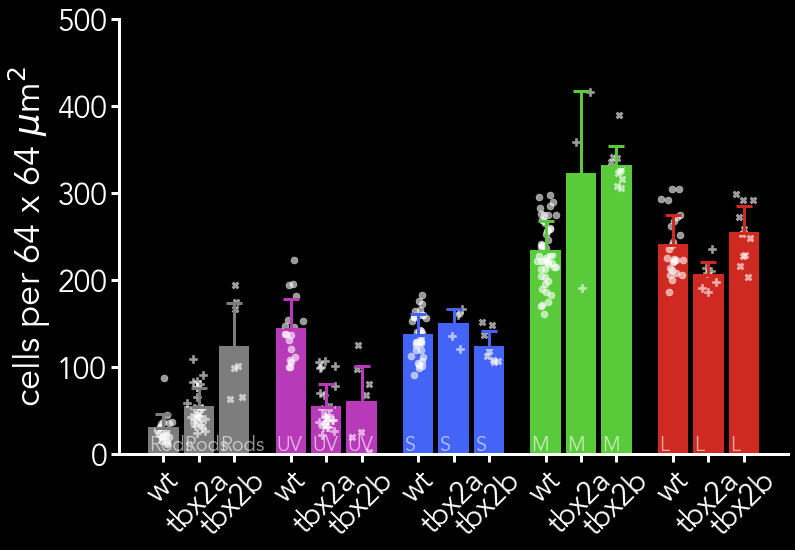

In [32]:
geneList = ['wt','tbx2a','tbx2b']
photoreceptors = ['R','U','S','M','L']

plotname = ''
fH, axH = plt.subplots(figsize= [12,8])

barW = np.size(geneList)+2; # bar width
barD = np.size(geneList)+1; # bar distance whitin 1 photoreceptor subtype
barP = -np.size(geneList)+1; # position in x-axis
barStep = 0.9; # distance between photoreceptor groups
barPos = []; #array to save bar positions


j=barP;
for gene in geneList:
    i=0;
    j=j+1;
    for pr in photoreceptors:
        i = i+barStep;
        if gene == 'wt':
            geno = 0
        else:
            geno = 1
        countData = df[(df['CRgene']==gene) & (df['Genotype']==geno)][pr]
        jitter = np.random.randn(len(countData))*0.03
#         textindent = 1/(2.5*barD);
        textindent = 0.10;
        pH = plt.bar([i+j/barD], np.mean(countData), width=1/barW, color=lighten_color(zfC[pr],1), linewidth = 2, edgecolor = lighten_color(zfC[pr],1)); #color=zfC[pr], 
#         pH = plt.bar([i+j/barD], np.mean(countData), yerr = sem(df[(df['CRgene']==gene) & (df['Genotype']==geno)][pr][~np.isnan(df[(df['CRgene']==gene) & (df['Genotype']==geno)][pr])], ddof = 0), align='center', ecolor='black', capsize=10, width=1/barW, color=zfC[pr], edgecolor = zfC[pr]);
#         pH = plt.bar([i+j/barD], np.mean(countData), yerr = np.std(df[(df['CRgene']==gene) & (df['Genotype']==geno)][pr][~np.isnan(df[(df['CRgene']==gene) & (df['Genotype']==geno)][pr])], ddof = 0), align='center', ecolor='black', capsize=10, width=1/barW, color=zfC[pr], edgecolor = zfC[pr]);
       # pH = plt.bar([i+j/barD], np.mean(df[(df['CRgene']==gene) & (df['Genotype']==geno)][pr]), yerr = np.std(df[(df['CRgene']==gene) & (df['Genotype']==geno)][pr]), ecolor=lighten_color(zfC[pr],1.2), capsize=10, width=1/barW, color=zfC[pr], edgecolor = zfC[pr]);
        #pH = plt.errorbar([i+j/barD], np.mean(df[(df['CRgene']==gene) & (df['Genotype']==geno)][pr]), yerr = np.std(df[(df['CRgene']==gene) & (df['Genotype']==geno)][pr]), ecolor=lighten_color(zfC[pr],1.1), elinewidth=2, capsize=5, capthick=2, barsabove= True)
#         pH = plt.scatter(np.ones(len(countData))*[i+j/barD]+jitter, countData, color=lighten_color(zfC[pr],2/3), zorder=2, marker = zfGm[gene], edgecolor='#ffffff', linewidth=0.5, alpha = 0.4);
        pH = plt.errorbar(i+j/barD, np.mean(countData), yerr = [[0],[np.std(countData)]], ecolor=lighten_color(zfC[pr],1), elinewidth=3, capsize=8, capthick=3, zorder=9)
        plt.text((i+j/barD)-textindent, 3, prLabel[pr], font_properties=font_prop, fontsize=20, ha='left', alpha=0.6)
        pH = plt.scatter(np.ones(len(countData))*[i+j/barD]+jitter, countData, color='#ffffff', zorder=8, marker = zfGm[gene], s=50, edgecolor='#ffffff', linewidth=0.5, alpha = .6);
        barPos = np.append(barPos,(i+j/barD))

formatFigure(fH, axH, pH)
axH.set_xticks(np.sort(barPos));

axH.set_xticklabels(geneList * len(photoreceptors));
axH.set_ylim([0,500]); # this was 400

# savePath = 'C:/Users/pataklk/OneDrive - National Institutes of Health/zf/F0_Analysis/CRfoxq2F0/'
# savePath = "/Users/angueyraaristjm/OneDrive - National Institutes of Health/zf/F0_Analysis/CRfoxq2F0/"
# savePath = "/Users/angueyraaristjm/Documents/LiLab/Presentations/revealjs/resources/20211008_UCLA/"
# plt.savefig(savePath + "Counts_foxq2.png", transparent=True, format="png")
# plt.savefig(savePath + "Counts_foxq2_B.svg", transparent=True, format="svg")

## Rods vs UV cones for paper

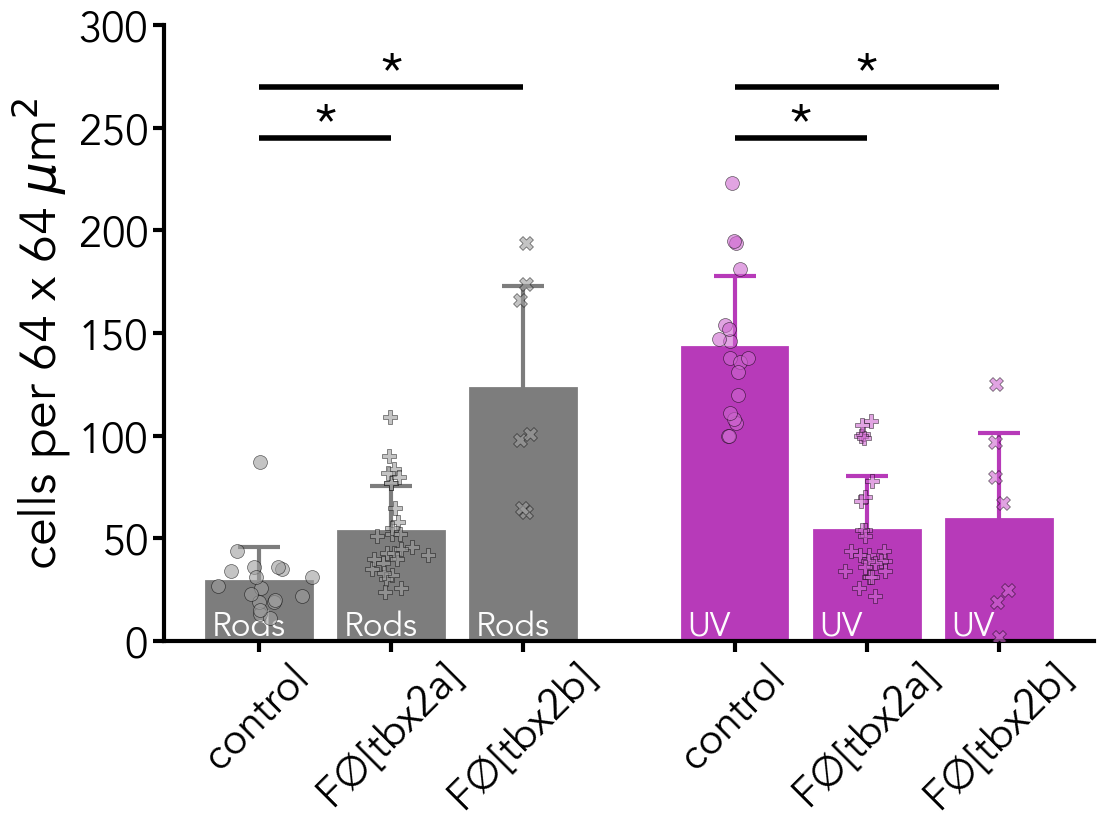

In [34]:
geneList = ['wt','tbx2a','tbx2b']
photoreceptors = ['R','U']

plotname = ''
fH, axH = plt.subplots(figsize= [12,8])
# fH, axH = plt.subplots(figsize= [12,8])

barW = np.size(geneList)+2; # bar width
barD = np.size(geneList)+1; # bar distance whitin 1 photoreceptor subtype
barP = -np.size(geneList)+1; # position in x-axis
barStep = 0.9; # distance between photoreceptor groups
barPos = []; #array to save bar positions


j=barP;
for gene in geneList:
    i=0;
    j=j+1;
    for pr in photoreceptors:
        i = i+barStep;
        if gene == 'wt':
            geno = 0
        else:
            geno = 1
        countData = df[(df['CRgene']==gene) & (df['Genotype']==geno)][pr]
        countData = countData[~np.isnan(countData)]
        jitter = estimateJitter(countData)*1.5
#         textindent = 1/(2.5*barD);
        textindent = 0.09;
        pH = plt.bar([i+j/barD], np.mean(countData), width=1/barW, color=lighten_color(zfC[pr],1), linewidth = 2, edgecolor = lighten_color(zfC[pr],1)); #color=zfC[pr], 
#         pH = plt.bar([i+j/barD], np.mean(countData), yerr = sem(df[(df['CRgene']==gene) & (df['Genotype']==geno)][pr][~np.isnan(df[(df['CRgene']==gene) & (df['Genotype']==geno)][pr])], ddof = 0), align='center', ecolor='black', capsize=10, width=1/barW, color=zfC[pr], edgecolor = zfC[pr]);
#         pH = plt.bar([i+j/barD], np.mean(countData), yerr = np.std(df[(df['CRgene']==gene) & (df['Genotype']==geno)][pr][~np.isnan(df[(df['CRgene']==gene) & (df['Genotype']==geno)][pr])], ddof = 0), align='center', ecolor='black', capsize=10, width=1/barW, color=zfC[pr], edgecolor = zfC[pr]);
       # pH = plt.bar([i+j/barD], np.mean(df[(df['CRgene']==gene) & (df['Genotype']==geno)][pr]), yerr = np.std(df[(df['CRgene']==gene) & (df['Genotype']==geno)][pr]), ecolor=lighten_color(zfC[pr],1.2), capsize=10, width=1/barW, color=zfC[pr], edgecolor = zfC[pr]);
        #pH = plt.errorbar([i+j/barD], np.mean(df[(df['CRgene']==gene) & (df['Genotype']==geno)][pr]), yerr = np.std(df[(df['CRgene']==gene) & (df['Genotype']==geno)][pr]), ecolor=lighten_color(zfC[pr],1.1), elinewidth=2, capsize=5, capthick=2, barsabove= True)
#         pH = plt.scatter(np.ones(len(countData))*[i+j/barD]+jitter, countData, color=lighten_color(zfC[pr],2/3), zorder=2, marker = zfGm[gene], edgecolor='#ffffff', linewidth=0.5, alpha = 0.4);
        pH = plt.errorbar(i+j/barD, np.mean(countData), yerr = [[2],[np.std(countData)]], ecolor=lighten_color(zfC[pr],1), elinewidth=3, capsize=15, capthick=3, zorder=7)
        plt.text((i+j/barD)-textindent, 3, prLabel[pr], font_properties=font_prop, fontsize=24, ha='left', alpha=0.99, color = '#ffffff', weight='bold')
        pH = plt.scatter(np.ones(len(countData))*[i+j/barD]+jitter, countData, color=lighten_color(zfC[pr],.75), zorder=8, marker = zfGm[gene], s=100, edgecolor=baseColor, linewidth=0.5, alpha = .6);
        barPos = np.append(barPos,(i+j/barD))

formatFigure(fH, axH, pH)
axH.set_xticks(np.sort(barPos));

geneList = ['control','F$\emptyset$[tbx2a]','F$\emptyset$[tbx2b]']

axH.set_xticklabels(geneList * len(photoreceptors));
axH.set_ylim([0,300]); # this was 400
stath = 245
hH = plt.hlines(stath, barPos[0], barPos[2], colors='#000000',linewidth=4)
plt.text((barPos[0]+barPos[2])/2, stath, '*', font_properties=font_prop, fontsize=36, ha='center')# plt.savefig(savePath + "Counts_tbx2_RU.svg", transparent=True, format="svg")
hH = plt.hlines(stath, barPos[1], barPos[3], colors='#000000',linewidth=4)
plt.text((barPos[1]+barPos[3])/2, stath, '*', font_properties=font_prop, fontsize=36, ha='center')# plt.savefig(savePath + "Counts_tbx2_RU.svg", transparent=True, format="svg")

stath = 270
hH = plt.hlines(stath, barPos[0], barPos[4], colors='#000000',linewidth=4)
plt.text((barPos[0]+barPos[4])/2, stath, '*', font_properties=font_prop, fontsize=36, ha='center')# plt.savefig(savePath + "Counts_tbx2_RU.svg", transparent=True, format="svg")
hH = plt.hlines(stath, barPos[1], barPos[5], colors='#000000',linewidth=4)
plt.text((barPos[1]+barPos[5])/2, stath, '*', font_properties=font_prop, fontsize=36, ha='center')# plt.savefig(savePath + "Counts_tbx2_RU.svg", transparent=True, format="svg")



dPath = '/Users/angueyraaristjm/OneDrive - National Institutes of Health/zf/Manuscripts/2021_zfConeRNAseq/resources/'
# dPath = '/Users/angueyraaristjm/Documents/LiLab/Presentations/revealjs/resources/20211008_UCLA/'
# plt.savefig(dPath + "CRtbx2F0_RU.svg", transparent=True, format="svg")


# # manually adding significance
# axH.set_ylim([0,400]); # this was 400
# hH = plt.hlines(375, barPos[0], barPos[1], colors='#ffffff',linewidth=4)
# plt.text((barPos[0]+barPos[1])/2, 375, '*', font_properties=font_prop, fontsize=36, ha='center')# plt.savefig(savePath + "Counts_tbx2_RU.svg", transparent=True, format="svg")
# plt.savefig(savePath + "Counts_tbx2a_L.svg", transparent=True, format="svg")



### L cones for paper

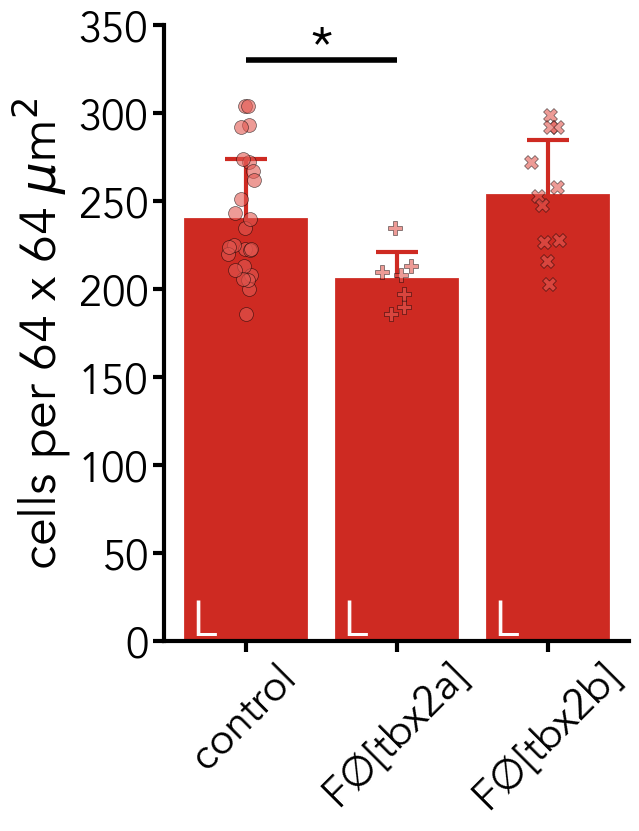

In [359]:
geneList = ['wt','tbx2a','tbx2b']
photoreceptors = ['L']

plotname = ''
fH, axH = plt.subplots(figsize= [6,8])
# fH, axH = plt.subplots(figsize= [12,8])

barW = np.size(geneList)+2; # bar width
barD = np.size(geneList)+1; # bar distance whitin 1 photoreceptor subtype
barP = -np.size(geneList)+1; # position in x-axis
barStep = 0.9; # distance between photoreceptor groups
barPos = []; #array to save bar positions


j=barP;
for gene in geneList:
    i=0;
    j=j+1;
    for pr in photoreceptors:
        i = i+barStep;
        if gene == 'wt':
            geno = 0
        else:
            geno = 1
        countData = df[(df['CRgene']==gene) & (df['Genotype']==geno)][pr]
        countData = countData[~np.isnan(countData)]
        jitter = estimateJitter(countData)*1.5
#         textindent = 1/(2.5*barD);
        textindent = 0.09;
        pH = plt.bar([i+j/barD], np.mean(countData), width=1/barW, color=lighten_color(zfC[pr],1), linewidth = 2, edgecolor = lighten_color(zfC[pr],1)); #color=zfC[pr], 
#         pH = plt.bar([i+j/barD], np.mean(countData), yerr = sem(df[(df['CRgene']==gene) & (df['Genotype']==geno)][pr][~np.isnan(df[(df['CRgene']==gene) & (df['Genotype']==geno)][pr])], ddof = 0), align='center', ecolor='black', capsize=10, width=1/barW, color=zfC[pr], edgecolor = zfC[pr]);
#         pH = plt.bar([i+j/barD], np.mean(countData), yerr = np.std(df[(df['CRgene']==gene) & (df['Genotype']==geno)][pr][~np.isnan(df[(df['CRgene']==gene) & (df['Genotype']==geno)][pr])], ddof = 0), align='center', ecolor='black', capsize=10, width=1/barW, color=zfC[pr], edgecolor = zfC[pr]);
       # pH = plt.bar([i+j/barD], np.mean(df[(df['CRgene']==gene) & (df['Genotype']==geno)][pr]), yerr = np.std(df[(df['CRgene']==gene) & (df['Genotype']==geno)][pr]), ecolor=lighten_color(zfC[pr],1.2), capsize=10, width=1/barW, color=zfC[pr], edgecolor = zfC[pr]);
        #pH = plt.errorbar([i+j/barD], np.mean(df[(df['CRgene']==gene) & (df['Genotype']==geno)][pr]), yerr = np.std(df[(df['CRgene']==gene) & (df['Genotype']==geno)][pr]), ecolor=lighten_color(zfC[pr],1.1), elinewidth=2, capsize=5, capthick=2, barsabove= True)
#         pH = plt.scatter(np.ones(len(countData))*[i+j/barD]+jitter, countData, color=lighten_color(zfC[pr],2/3), zorder=2, marker = zfGm[gene], edgecolor='#ffffff', linewidth=0.5, alpha = 0.4);
        pH = plt.errorbar(i+j/barD, np.mean(countData), yerr = [[2],[np.std(countData)]], ecolor=lighten_color(zfC[pr],1), elinewidth=3, capsize=15, capthick=3, zorder=7)
        plt.text((i+j/barD)-textindent, 3, prLabel[pr], font_properties=font_prop, fontsize=36, ha='left', alpha=0.99, color = '#ffffff')
        pH = plt.scatter(np.ones(len(countData))*[i+j/barD]+jitter, countData, color=lighten_color(zfC[pr],.75), zorder=8, marker = zfGm[gene], s=100, edgecolor=baseColor, linewidth=0.5, alpha = .6);
        barPos = np.append(barPos,(i+j/barD))

formatFigure(fH, axH, pH)
axH.set_xticks(np.sort(barPos));

geneList = ['control','F$\emptyset$[tbx2a]','F$\emptyset$[tbx2b]']

axH.set_xticklabels(geneList * len(photoreceptors));
axH.set_ylim([0,350]); # this was 400
stath = 330
hH = plt.hlines(stath, barPos[0], barPos[1], colors='#000000',linewidth=4)
plt.text((barPos[0]+barPos[1])/2, stath, '*', font_properties=font_prop, fontsize=36, ha='center')# plt.savefig(savePath + "Counts_tbx2_RU.svg", transparent=True, format="svg")



dPath = '/Users/angueyraaristjm/OneDrive - National Institutes of Health/zf/Manuscripts/2021_zfConeRNAseq/resources/'
# dPath = '/Users/angueyraaristjm/Documents/LiLab/Presentations/revealjs/resources/20211008_UCLA/'
plt.savefig(dPath + "CRtbx2F0_L.svg", transparent=True, format="svg")


# # manually adding significance
# axH.set_ylim([0,400]); # this was 400
# hH = plt.hlines(375, barPos[0], barPos[1], colors='#ffffff',linewidth=4)
# plt.text((barPos[0]+barPos[1])/2, 375, '*', font_properties=font_prop, fontsize=36, ha='center')# plt.savefig(savePath + "Counts_tbx2_RU.svg", transparent=True, format="svg")
# plt.savefig(savePath + "Counts_tbx2a_L.svg", transparent=True, format="svg")



### S cones for paper

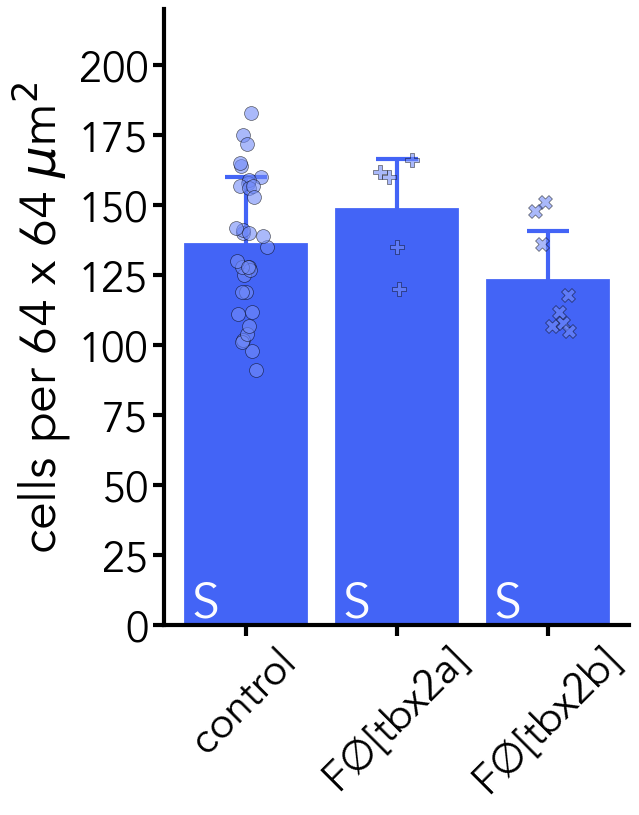

In [360]:
geneList = ['wt','tbx2a','tbx2b']
photoreceptors = ['S']

plotname = ''
fH, axH = plt.subplots(figsize= [6,8])
# fH, axH = plt.subplots(figsize= [12,8])

barW = np.size(geneList)+2; # bar width
barD = np.size(geneList)+1; # bar distance whitin 1 photoreceptor subtype
barP = -np.size(geneList)+1; # position in x-axis
barStep = 0.9; # distance between photoreceptor groups
barPos = []; #array to save bar positions


j=barP;
for gene in geneList:
    i=0;
    j=j+1;
    for pr in photoreceptors:
        i = i+barStep;
        if gene == 'wt':
            geno = 0
        else:
            geno = 1
        countData = df[(df['CRgene']==gene) & (df['Genotype']==geno)][pr]
        countData = countData[~np.isnan(countData)]
        jitter = estimateJitter(countData)*1.5
#         textindent = 1/(2.5*barD);
        textindent = 0.09;
        pH = plt.bar([i+j/barD], np.mean(countData), width=1/barW, color=lighten_color(zfC[pr],1), linewidth = 2, edgecolor = lighten_color(zfC[pr],1)); #color=zfC[pr], 
#         pH = plt.bar([i+j/barD], np.mean(countData), yerr = sem(df[(df['CRgene']==gene) & (df['Genotype']==geno)][pr][~np.isnan(df[(df['CRgene']==gene) & (df['Genotype']==geno)][pr])], ddof = 0), align='center', ecolor='black', capsize=10, width=1/barW, color=zfC[pr], edgecolor = zfC[pr]);
#         pH = plt.bar([i+j/barD], np.mean(countData), yerr = np.std(df[(df['CRgene']==gene) & (df['Genotype']==geno)][pr][~np.isnan(df[(df['CRgene']==gene) & (df['Genotype']==geno)][pr])], ddof = 0), align='center', ecolor='black', capsize=10, width=1/barW, color=zfC[pr], edgecolor = zfC[pr]);
       # pH = plt.bar([i+j/barD], np.mean(df[(df['CRgene']==gene) & (df['Genotype']==geno)][pr]), yerr = np.std(df[(df['CRgene']==gene) & (df['Genotype']==geno)][pr]), ecolor=lighten_color(zfC[pr],1.2), capsize=10, width=1/barW, color=zfC[pr], edgecolor = zfC[pr]);
        #pH = plt.errorbar([i+j/barD], np.mean(df[(df['CRgene']==gene) & (df['Genotype']==geno)][pr]), yerr = np.std(df[(df['CRgene']==gene) & (df['Genotype']==geno)][pr]), ecolor=lighten_color(zfC[pr],1.1), elinewidth=2, capsize=5, capthick=2, barsabove= True)
#         pH = plt.scatter(np.ones(len(countData))*[i+j/barD]+jitter, countData, color=lighten_color(zfC[pr],2/3), zorder=2, marker = zfGm[gene], edgecolor='#ffffff', linewidth=0.5, alpha = 0.4);
        pH = plt.errorbar(i+j/barD, np.mean(countData), yerr = [[2],[np.std(countData)]], ecolor=lighten_color(zfC[pr],1), elinewidth=3, capsize=15, capthick=3, zorder=7)
        plt.text((i+j/barD)-textindent, 3, prLabel[pr], font_properties=font_prop, fontsize=36, ha='left', alpha=0.99, color = '#ffffff')
        pH = plt.scatter(np.ones(len(countData))*[i+j/barD]+jitter, countData, color=lighten_color(zfC[pr],.75), zorder=8, marker = zfGm[gene], s=100, edgecolor=baseColor, linewidth=0.5, alpha = .6);
        barPos = np.append(barPos,(i+j/barD))

formatFigure(fH, axH, pH)
axH.set_xticks(np.sort(barPos));

geneList = ['control','F$\emptyset$[tbx2a]','F$\emptyset$[tbx2b]']

axH.set_xticklabels(geneList * len(photoreceptors));
axH.set_ylim([0,220]); # this was 400



dPath = '/Users/angueyraaristjm/OneDrive - National Institutes of Health/zf/Manuscripts/2021_zfConeRNAseq/resources/'
# dPath = '/Users/angueyraaristjm/Documents/LiLab/Presentations/revealjs/resources/20211008_UCLA/'
plt.savefig(dPath + "CRtbx2F0_S.svg", transparent=True, format="svg")


# # manually adding significance
# axH.set_ylim([0,400]); # this was 400
# hH = plt.hlines(375, barPos[0], barPos[1], colors='#ffffff',linewidth=4)
# plt.text((barPos[0]+barPos[1])/2, 375, '*', font_properties=font_prop, fontsize=36, ha='center')# plt.savefig(savePath + "Counts_tbx2_RU.svg", transparent=True, format="svg")
# plt.savefig(savePath + "Counts_tbx2a_L.svg", transparent=True, format="svg")



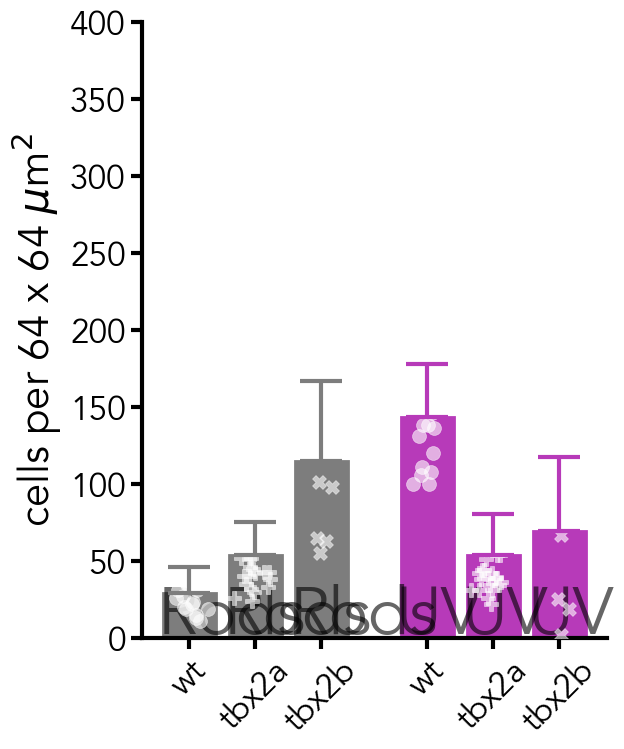

In [331]:
geneList = ['wt','tbx2a','tbx2b']
# photoreceptors = ['R','U','S','M','L']

# geneList = ['wt','tbx2b']
photoreceptors = ['R','U']
# geneList = ['wt','tbx2a','tbx2b']
# photoreceptors = ['R','U']

# geneList = ['wt','tbx2b']
# photoreceptors = ['S']

plotname = ''
fH, axH = plt.subplots(figsize= [6,8])
# fH, axH = plt.subplots(figsize= [12,8])

barW = np.size(geneList)+2; # bar width
barD = np.size(geneList)+1; # bar distance whitin 1 photoreceptor subtype
barP = -np.size(geneList)+1; # position in x-axis
barStep = 0.9; # distance between photoreceptor groups
barPos = []; #array to save bar positions


j=barP;
for gene in geneList:
    i=0;
    j=j+1;
    for pr in photoreceptors:
        i = i+barStep;
        if gene == 'wt':
            geno = 0
        else:
            geno = 1
        countData = df[(df['CRgene']==gene) & (df['Genotype']==geno)][pr]
        jitter = np.random.randn(len(countData))*0.03
#         textindent = 1/(2.5*barD);
        textindent = 0.12;
        pH = plt.bar([i+j/barD], np.mean(countData), width=1/barW, color=lighten_color(zfC[pr],1), linewidth = 2, edgecolor = lighten_color(zfC[pr],1)); #color=zfC[pr], 
#         pH = plt.bar([i+j/barD], np.mean(countData), yerr = sem(df[(df['CRgene']==gene) & (df['Genotype']==geno)][pr][~np.isnan(df[(df['CRgene']==gene) & (df['Genotype']==geno)][pr])], ddof = 0), align='center', ecolor='black', capsize=10, width=1/barW, color=zfC[pr], edgecolor = zfC[pr]);
#         pH = plt.bar([i+j/barD], np.mean(countData), yerr = np.std(df[(df['CRgene']==gene) & (df['Genotype']==geno)][pr][~np.isnan(df[(df['CRgene']==gene) & (df['Genotype']==geno)][pr])], ddof = 0), align='center', ecolor='black', capsize=10, width=1/barW, color=zfC[pr], edgecolor = zfC[pr]);
       # pH = plt.bar([i+j/barD], np.mean(df[(df['CRgene']==gene) & (df['Genotype']==geno)][pr]), yerr = np.std(df[(df['CRgene']==gene) & (df['Genotype']==geno)][pr]), ecolor=lighten_color(zfC[pr],1.2), capsize=10, width=1/barW, color=zfC[pr], edgecolor = zfC[pr]);
        #pH = plt.errorbar([i+j/barD], np.mean(df[(df['CRgene']==gene) & (df['Genotype']==geno)][pr]), yerr = np.std(df[(df['CRgene']==gene) & (df['Genotype']==geno)][pr]), ecolor=lighten_color(zfC[pr],1.1), elinewidth=2, capsize=5, capthick=2, barsabove= True)
#         pH = plt.scatter(np.ones(len(countData))*[i+j/barD]+jitter, countData, color=lighten_color(zfC[pr],2/3), zorder=2, marker = zfGm[gene], edgecolor='#ffffff', linewidth=0.5, alpha = 0.4);
        pH = plt.errorbar(i+j/barD, np.mean(countData), yerr = [[0],[np.std(countData)]], ecolor=lighten_color(zfC[pr],1), elinewidth=3, capsize=15, capthick=3, zorder=9)
        plt.text((i+j/barD)-textindent, 3, prLabel[pr], font_properties=font_prop, fontsize=48, ha='left', alpha=0.6)
        pH = plt.scatter(np.ones(len(countData))*[i+j/barD]+jitter, countData, color='#ffffff', zorder=8, marker = zfGm[gene], s=100, edgecolor='#ffffff', linewidth=0.5, alpha = .6);
        barPos = np.append(barPos,(i+j/barD))

formatFigure(fH, axH, pH)
axH.set_xticks(np.sort(barPos));

axH.set_xticklabels(geneList * len(photoreceptors));
axH.set_ylim([0,400]); # this was 400

# savePath = 'C:/Users/pataklk/OneDrive - National Institutes of Health/zf/F0_Analysis/CRfoxq2F0/'
# savePath = "/Users/angueyraaristjm/OneDrive - National Institutes of Health/zf/F0_Analysis/CRfoxq2F0/"
savePath = "/Users/angueyraaristjm/Documents/LiLab/Presentations/revealjs/resources/20211008_UCLA/"
# plt.savefig(savePath + "Counts_foxq2.png", transparent=True, format="png")


# manually adding significance
# axH.set_ylim([0,225]); # this was 400
# plt.savefig(savePath + "Counts_tbx2b_S.svg", transparent=True, format="svg")

# # manually adding significance
# axH.set_ylim([0,400]); # this was 400
# hH = plt.hlines(375, barPos[0], barPos[1], colors='#ffffff',linewidth=4)
# plt.text((barPos[0]+barPos[1])/2, 375, '*', font_properties=font_prop, fontsize=36, ha='center')# plt.savefig(savePath + "Counts_tbx2_RU.svg", transparent=True, format="svg")
# plt.savefig(savePath + "Counts_tbx2a_L.svg", transparent=True, format="svg")


# manually adding significance
# axH.set_ylim([0,300]); # this was 400
# hH = plt.hlines(240, barPos[0], barPos[2], colors='#ffffff',linewidth=4)
# plt.text((barPos[0]+barPos[2])/2, 240, '*', font_properties=font_prop, fontsize=36, ha='center')
# hH = plt.hlines(265, barPos[0], barPos[4], colors='#ffffff',linewidth=4)
# plt.text((barPos[0]+barPos[4])/2, 265, '*', font_properties=font_prop, fontsize=36, ha='center')
# hH = plt.hlines(240, barPos[1], barPos[3], colors='#ffffff',linewidth=4)
# plt.text((barPos[1]+barPos[3])/2, 240, '*', font_properties=font_prop, fontsize=36, ha='center')
# hH = plt.hlines(265, barPos[1], barPos[5], colors='#ffffff',linewidth=4)
# plt.text((barPos[1]+barPos[5])/2, 265, '*', font_properties=font_prop, fontsize=36, ha='center')
# plt.savefig(savePath + "Counts_tbx2_RU.svg", transparent=True, format="svg")


# # manually adding significance
# axH.set_ylim([0,250]); # this was 400
# hH = plt.hlines(235, barPos[0], barPos[2], colors='#ffffff',linewidth=4)
# plt.text((barPos[0]+barPos[2])/2, 235, '*', font_properties=font_prop, fontsize=36, ha='center')
# hH = plt.hlines(235, barPos[1], barPos[3], colors='#ffffff',linewidth=4)
# plt.text((barPos[1]+barPos[3])/2, 235, '*', font_properties=font_prop, fontsize=36, ha='center')
# plt.savefig(savePath + "Counts_tbx2b_RU.svg", transparent=True, format="svg")

In [192]:
barD

4

# Stats

In [291]:
# Excluding the NaNs and mismatched genotyped ones 
Rwt = df[(df['CRgene']==('wt'))&(df['Genotype']==0)]['R']
Rwt = Rwt[~np.isnan(Rwt)]
Rtbx2a = df[(df['CRgene']==('tbx2a'))&(df['Genotype']==1)]['R']
Rtbx2a = Rtbx2a[~np.isnan(Rtbx2a)]
Rtbx2b = df[(df['CRgene']==('tbx2b'))&(df['Genotype']==1)]['R']
Rtbx2b = Rtbx2b[~np.isnan(Rtbx2b)]
Rfoxq2 = df[(df['CRgene']==('foxq2'))&(df['Genotype']==1)]['R']
Rfoxq2 = Rfoxq2[~np.isnan(Rfoxq2)]

Uwt = df[(df['CRgene']==('wt'))&(df['Genotype']==0)]['U']
Uwt = Uwt[~np.isnan(Uwt)]
Utbx2a = df[(df['CRgene']==('tbx2a'))&(df['Genotype']==1)]['U']
Utbx2a = Utbx2a[~np.isnan(Utbx2a)]
Utbx2b = df[(df['CRgene']==('tbx2b'))&(df['Genotype']==1)]['U']
Utbx2b = Utbx2b[~np.isnan(Utbx2b)]
Ufoxq2 = df[(df['CRgene']==('foxq2'))&(df['Genotype']==1)]['U']
Ufoxq2 = Ufoxq2[~np.isnan(Ufoxq2)]

Swt = df[(df['CRgene']==('wt'))&(df['Genotype']==0)]['S']
Swt = Swt[~np.isnan(Swt)]
Stbx2a = df[(df['CRgene']==('tbx2a'))&(df['Genotype']==1)]['S']
Stbx2a = Stbx2a[~np.isnan(Stbx2a)]
Stbx2b = df[(df['CRgene']==('tbx2b'))&(df['Genotype']==1)]['S']
Stbx2b = Stbx2b[~np.isnan(Stbx2b)]
Sfoxq2 = df[(df['CRgene']==('foxq2'))&(df['Genotype']==1)]['S']
Sfoxq2 = Sfoxq2[~np.isnan(Sfoxq2)]

Mwt = df[(df['CRgene']==('wt'))&(df['Genotype']==0)]['M']
Mwt = Mwt[~np.isnan(Mwt)]
Mtbx2a = df[(df['CRgene']==('tbx2a'))&(df['Genotype']==1)]['M']
Mtbx2a = Mtbx2a[~np.isnan(Mtbx2a)]
Mtbx2b = df[(df['CRgene']==('tbx2b'))&(df['Genotype']==1)]['M']
Mtbx2b = Mtbx2b[~np.isnan(Mtbx2b)]
Mfoxq2 = df[(df['CRgene']==('foxq2'))&(df['Genotype']==1)]['M']
Mfoxq2 = Mfoxq2[~np.isnan(Mfoxq2)]

Lwt = df[(df['CRgene']==('wt'))&(df['Genotype']==0)]['L']
Lwt = Lwt[~np.isnan(Lwt)]
Ltbx2a = df[(df['CRgene']==('tbx2a'))&(df['Genotype']==1)]['L']
Ltbx2a = Ltbx2a[~np.isnan(Ltbx2a)]
Ltbx2b = df[(df['CRgene']==('tbx2b'))&(df['Genotype']==1)]['L']
Ltbx2b = Ltbx2b[~np.isnan(Ltbx2b)]
Lfoxq2 = df[(df['CRgene']==('foxq2'))&(df['Genotype']==1)]['L']
Lfoxq2 = Lfoxq2[~np.isnan(Lfoxq2)]


In [332]:
# Mann Whitney 
Su, pS = mannwhitneyu(Swt, Stbx2a)
Mu, pM = mannwhitneyu(Mwt, Mtbx2a)
Lu, pL = mannwhitneyu(Lwt, Ltbx2a)
Uu, pU = mannwhitneyu(Uwt, Utbx2a)
Ru, pR = mannwhitneyu(Rwt, Rtbx2a)
print('wt vs. tbx2a:')
print('\tR: U = {0:.3f}, p = {1:.5f}, nEyes: wt = {2:.0f}; tbx2a = {3:.0f}'.format(Ru,pR,len(Rwt),len(Rtbx2a)))
print('\tU: U = {0:.3f}, p = {1:.5f}, nEyes: wt = {2:.0f}; tbx2a = {3:.0f}'.format(Uu,pU,len(Uwt),len(Utbx2a)))
print('\tS: U = {0:.3f}, p = {1:.5f}, nEyes: wt = {2:.0f}; tbx2a = {3:.0f}'.format(Su,pS,len(Swt),len(Stbx2a)))
print('\tM: U = {0:.3f}, p = {1:.5f}, nEyes: wt = {2:.0f}; tbx2a = {3:.0f}'.format(Mu,pM,len(Mwt),len(Mtbx2a)))
print('\tL: U = {0:.3f}, p = {1:.5f}, nEyes: wt = {2:.0f}; tbx2a = {3:.0f}'.format(Lu,pL,len(Lwt),len(Ltbx2a)))
Su, pS = mannwhitneyu(Swt, Stbx2b)
Mu, pM = mannwhitneyu(Mwt, Mtbx2b)
Lu, pL = mannwhitneyu(Lwt, Ltbx2b)
Uu, pU = mannwhitneyu(Uwt, Utbx2b)
Ru, pR = mannwhitneyu(Rwt, Rtbx2b)
print('wt vs. tbx2b:')
print('\tR: U = {0:.3f}, p = {1:.5f}, nEyes: wt = {2:.0f}; tbx2b = {3:.0f}'.format(Ru,pR,len(Rwt),len(Rtbx2b)))
print('\tU: U = {0:.3f}, p = {1:.5f}, nEyes: wt = {2:.0f}; tbx2b = {3:.0f}'.format(Uu,pU,len(Uwt),len(Utbx2b)))
print('\tS: U = {0:.3f}, p = {1:.5f}, nEyes: wt = {2:.0f}; tbx2b = {3:.0f}'.format(Su,pS,len(Swt),len(Stbx2b)))
print('\tM: U = {0:.3f}, p = {1:.5f}, nEyes: wt = {2:.0f}; tbx2b = {3:.0f}'.format(Mu,pM,len(Mwt),len(Mtbx2b)))
print('\tL: U = {0:.3f}, p = {1:.5f}, nEyes: wt = {2:.0f}; tbx2b = {3:.0f}'.format(Lu,pL,len(Lwt),len(Ltbx2b)))
Su, pS = mannwhitneyu(Swt, Sfoxq2)
Mu, pM = mannwhitneyu(Mwt, Mfoxq2)
Lu, pL = mannwhitneyu(Lwt, Lfoxq2)
Uu, pU = mannwhitneyu(UVwt, UVfoxq2)
Ru, pR = mannwhitneyu(Rwt, Rfoxq2)
print('wt vs. foxq2:')
print('\tR: U = {0:.3f}, p = {1:.5f}, nEyes: wt = {2:.0f}; foxq2 = {3:.0f}'.format(Ru,pR,len(Rwt),len(Rfoxq2)))
print('\tU: U = {0:.3f}, p = {1:.5f}, nEyes: wt = {2:.0f}; foxq2 = {3:.0f}'.format(Uu,pU,len(Uwt),len(Ufoxq2)))
print('\tS: U = {0:.3f}, p = {1:.5f}, nEyes: wt = {2:.0f}; foxq2 = {3:.0f}'.format(Su,pS,len(Swt),len(Sfoxq2)))
print('\tM: U = {0:.3f}, p = {1:.5f}, nEyes: wt = {2:.0f}; foxq2 = {3:.0f}'.format(Mu,pM,len(Mwt),len(Mfoxq2)))
print('\tL: U = {0:.3f}, p = {1:.5f}, nEyes: wt = {2:.0f}; foxq2 = {3:.0f}'.format(Lu,pL,len(Lwt),len(Lfoxq2)))




wt vs. tbx2a:
	R: U = 69.000, p = 0.00006, nEyes: wt = 18; tbx2a = 27
	U: U = 478.000, p = 0.00000, nEyes: wt = 18; tbx2a = 27
	S: U = 55.000, p = 0.21504, nEyes: wt = 34; tbx2a = 5
	M: U = 42.000, p = 0.22367, nEyes: wt = 49; tbx2a = 3
	L: U = 143.000, p = 0.01212, nEyes: wt = 25; tbx2a = 7
wt vs. tbx2b:
	R: U = 3.000, p = 0.00014, nEyes: wt = 18; tbx2b = 8
	U: U = 128.000, p = 0.00204, nEyes: wt = 18; tbx2b = 8
	S: U = 179.000, p = 0.17326, nEyes: wt = 34; tbx2b = 8
	M: U = 0.000, p = 0.00000, nEyes: wt = 49; tbx2b = 10
	L: U = 104.500, p = 0.26416, nEyes: wt = 25; tbx2b = 11
wt vs. foxq2:
	R: U = 61.000, p = 0.92747, nEyes: wt = 18; foxq2 = 7
	U: U = 57.000, p = 0.73899, nEyes: wt = 18; foxq2 = 7
	S: U = 709.000, p = 0.00000, nEyes: wt = 34; foxq2 = 21
	M: U = 870.500, p = 0.36856, nEyes: wt = 49; foxq2 = 40
	L: U = 161.000, p = 0.97545, nEyes: wt = 25; foxq2 = 13


In [297]:
len(Rwt)

18

***
## foxq2 F&empty;<a id='foxq2F0'>∮</a>
***
[Back to Index](#Index)

In [372]:
#dPath = "/Users/angueyraaristjm/Documents/LiImaging/Analysis/CRfoxq2F0/"
# dPath = "C:/Users/pataklk/OneDrive - National Institutes of Health/zf/F0_Analysis/CRfoxq2F0/"
dPath = "/Users/angueyraaristjm/OneDrive - National Institutes of Health/zf/F0_Analysis/CRfoxq2F0/"
fName = "CRfoxq2ResultsAll_Updated.csv"

dPath = "/Users/angueyraaristjm/OneDrive - National Institutes of Health/zf/F0_Analysis/"
fName = "countResultsCombined.csv"

df = pd.read_csv(dPath + fName)
df

,filename,CRgene,R,U,S,M,L,Geno,Genotype
0,20200821_5dpf_xOG_s1mCh_CRtbx2a_i05b,tbx2a,43.0,70.0,NaN,NaN,NaN,mut,1.0
1,20200821_5dpf_xOG_s1mCh_CRtbx2a_i05d,tbx2a,35.0,101.0,NaN,NaN,NaN,mut,1.0
2,20200821_5dpf_xOG_s1mCh_CRtbx2a_i06b,tbx2a,77.0,39.0,NaN,NaN,NaN,mut,1.0
3,20200821_5dpf_xOG_s1mCh_CRtbx2a_i06d,tbx2a,58.0,44.0,NaN,NaN,NaN,mut,1.0
4,20200821_5dpf_xOG_s1mCh_CRtbx2a_i07b,tbx2a,65.0,68.0,NaN,NaN,NaN,mut,1.0
...,...,...,...,...,...,...,...,...,...
219,20210716_5dpf_t2T_m2G_mZpr1405_rbSopCy5_uninj_...,wt,NaN,NaN,NaN,267.0,220.0,wt,0.0
220,20210716_5dpf_t2T_m2G_mZpr1405_rbSopCy5_uninj_...,wt,NaN,NaN,NaN,183.0,224.0,wt,0.0
221,20210716_5dpf_t2T_m2G_mZpr1405_rbSopCy5_uninj_...,wt,NaN,NaN,NaN,253.0,211.0,wt,0.0
222,20210716_5dpf_t2T_m2G_mZpr1405_rbSopCy5_uninj_...,wt,NaN,NaN,NaN,275.0,243.0,wt,0.0


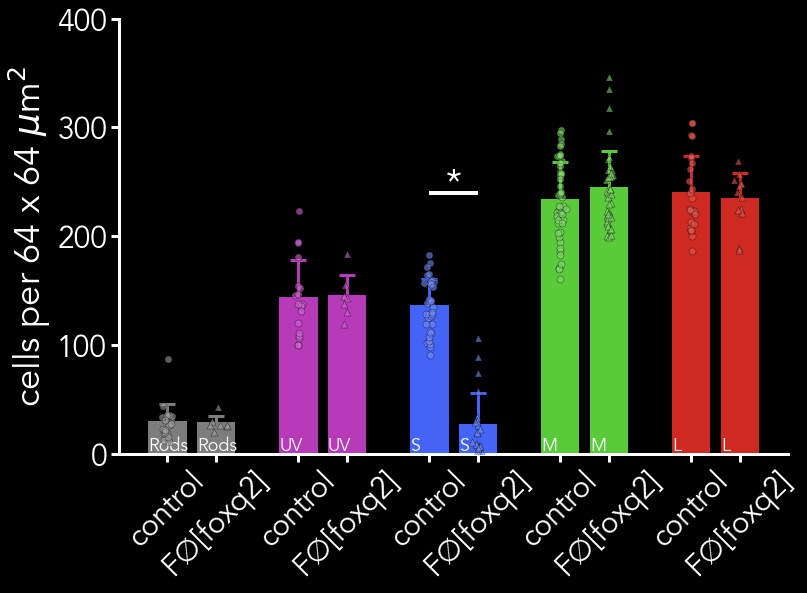

In [6]:
geneList = ['wt','foxq2']
photoreceptors = ['R','U','S','M','L']

plotname = ''
fH, axH = plt.subplots(figsize= [12,8])

barW = np.size(geneList)+2; # bar width
barD = np.size(geneList)+1; # bar distance whitin 1 photoreceptor subtype
barP = -np.size(geneList)+1; # position in x-axis
barStep = 0.9; # distance between photoreceptor groups
barPos = []; #array to save bar positions


j=barP;
for gene in geneList:
    i=0;
    j=j+1;
    for pr in photoreceptors:
        i = i+barStep;
        if gene == 'wt':
            geno = 0
        else:
            geno = 1
        countData = df[(df['CRgene']==gene) & (df['Genotype']==geno)][pr]
        countData = countData[~np.isnan(countData)]
        jitter = estimateJitter(countData)*1.25
#         textindent = 1/(2.5*barD);
        textindent = 0.13;
        pH = plt.bar([i+j/barD], np.mean(countData), width=1/barW, color=lighten_color(zfC[pr],1), linewidth = 2, edgecolor = lighten_color(zfC[pr],1)); #color=zfC[pr], 
#         pH = plt.bar([i+j/barD], np.mean(countData), yerr = sem(df[(df['CRgene']==gene) & (df['Genotype']==geno)][pr][~np.isnan(df[(df['CRgene']==gene) & (df['Genotype']==geno)][pr])], ddof = 0), align='center', ecolor='black', capsize=10, width=1/barW, color=zfC[pr], edgecolor = zfC[pr]);
#         pH = plt.bar([i+j/barD], np.mean(countData), yerr = np.std(df[(df['CRgene']==gene) & (df['Genotype']==geno)][pr][~np.isnan(df[(df['CRgene']==gene) & (df['Genotype']==geno)][pr])], ddof = 0), align='center', ecolor='black', capsize=10, width=1/barW, color=zfC[pr], edgecolor = zfC[pr]);
       # pH = plt.bar([i+j/barD], np.mean(df[(df['CRgene']==gene) & (df['Genotype']==geno)][pr]), yerr = np.std(df[(df['CRgene']==gene) & (df['Genotype']==geno)][pr]), ecolor=lighten_color(zfC[pr],1.2), capsize=10, width=1/barW, color=zfC[pr], edgecolor = zfC[pr]);
        #pH = plt.errorbar([i+j/barD], np.mean(df[(df['CRgene']==gene) & (df['Genotype']==geno)][pr]), yerr = np.std(df[(df['CRgene']==gene) & (df['Genotype']==geno)][pr]), ecolor=lighten_color(zfC[pr],1.1), elinewidth=2, capsize=5, capthick=2, barsabove= True)
#         pH = plt.scatter(np.ones(len(countData))*[i+j/barD]+jitter, countData, color=lighten_color(zfC[pr],2/3), zorder=2, marker = zfGm[gene], edgecolor='#ffffff', linewidth=0.5, alpha = 0.4);
        pH = plt.errorbar(i+j/barD, np.mean(countData), yerr = [[5],[np.std(countData)]], ecolor=lighten_color(zfC[pr],1), elinewidth=3, capsize=8, capthick=3, zorder=7)
        plt.text((i+j/barD)-textindent, 3, prLabel[pr], font_properties=font_prop, fontsize=18, ha='left', alpha=0.99, color = '#ffffff')
#         pH = plt.scatter(np.ones(len(countData))*[i+j/barD]+jitter, countData, color='#ffffff', zorder=8, marker = zfGm[gene], s=50, edgecolor='#ffffff', linewidth=0.5, alpha = .6);
        pH = plt.scatter(np.ones(len(countData))*[i+j/barD]+jitter, countData, color=lighten_color(zfC[pr],.75), zorder=8, marker = zfGm[gene], s=50, edgecolor='#000000', linewidth=0.5, alpha = .6);
        barPos = np.append(barPos,(i+j/barD))

formatFigure(fH, axH, pH)
axH.set_xticks(np.sort(barPos));
axH.set_yticks([0,100,200,300,400]);

geneList = ['control','F$\emptyset$[foxq2]']

axH.set_xticklabels(geneList * len(photoreceptors));
axH.set_ylim([0,400]); # this was 400

# manually adding significance
hH = plt.hlines(240, barPos[2], barPos[7], colors=baseColor,linewidth=4)
plt.text((barPos[2]+barPos[7])/2, 240, '*', font_properties=font_prop, fontsize=36, ha='center')


# savePath = 'C:/Users/pataklk/OneDrive - National Institutes of Health/zf/F0_Analysis/CRfoxq2F0/'
# savePath = "/Users/angueyraaristjm/OneDrive - National Institutes of Health/zf/F0_Analysis/CRfoxq2F0/"
savePath = "/Users/angueyraaristjm/Documents/LiLab/Presentations/revealjs/resources/20211008_UCLA/"
# savePath = '/Users/angueyraaristjm/OneDrive - National Institutes of Health/zf/Manuscripts/2021_zfConeRNAseq/resources/'
# plt.savefig(savePath + "foxq2Counts.svg", transparent=True, format="svg")

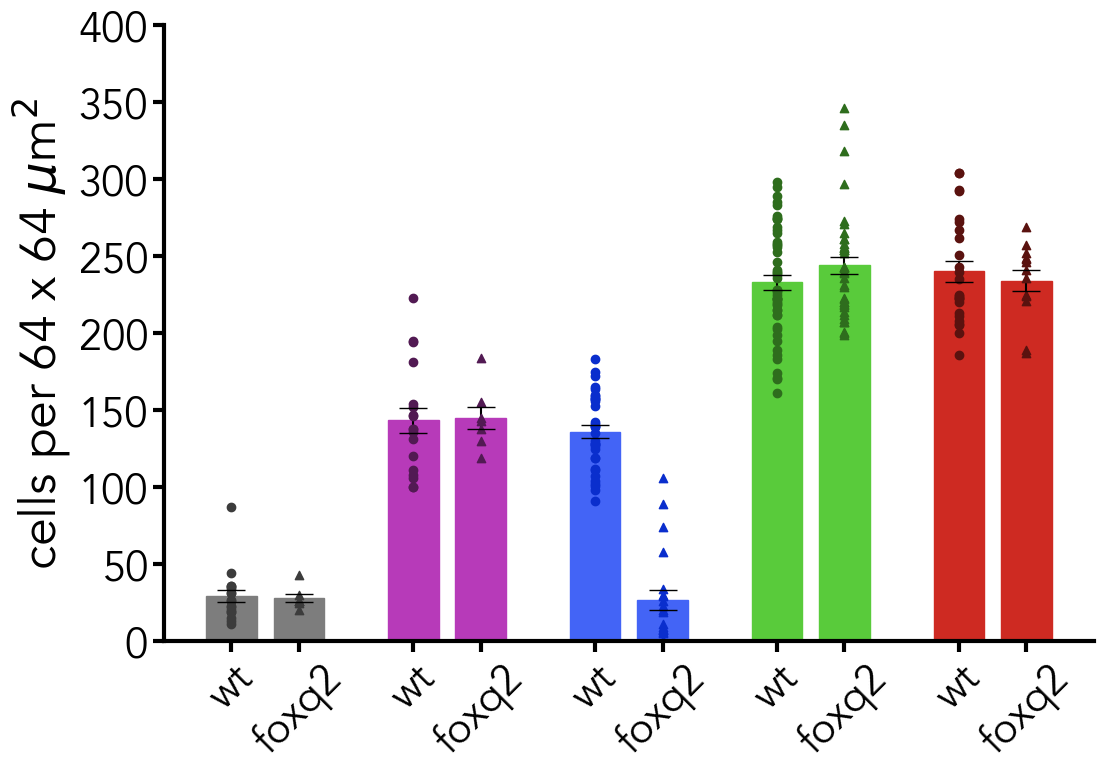

In [8]:
# Single PR subtype with exclusions: 

geneList = ['wt','foxq2']
photoreceptors = ['R','U','S','M','L']
# photoreceptors = ['L']

plotname = ''
fH, axH = plt.subplots(figsize= [12,8])

barW = np.size(geneList)+2; # bar width
barD = np.size(geneList)+1; # bar distance whitin 1 photoreceptor subtype
barP = -np.size(geneList)+1; # position in x-axis
barStep = 0.9; # distance between photoreceptor groups
barPos = []; #array to save bar positions

j=barP;
for gene in geneList:
    i=0;
    j=j+1;
    for pr in photoreceptors:
        i = i+barStep;
        if gene == 'wt':
            geno = 0
        else:
            geno = 1
        pH = plt.bar([i+j/barD], np.mean(df[(df['CRgene']==gene) & (df['Genotype']==geno)][pr]), yerr = sem(df[(df['CRgene']==gene) & (df['Genotype']==geno)][pr][~np.isnan(df[(df['CRgene']==gene) & (df['Genotype']==geno)][pr])], ddof = 0), align='center', ecolor='black', capsize=10, width=1/barW, color=zfC[pr], edgecolor = zfC[pr]);
        pH = plt.scatter(np.ones(len(df[(df['CRgene']==gene) & (df['Genotype']==geno)][pr]))*[i+j/barD], df[(df['CRgene']==gene) & (df['Genotype']==geno)][pr], color=lighten_color(zfC[pr],1.5), zorder=2, marker = zfGm[gene]);
        barPos = np.append(barPos,(i+j/barD))

# import matplotlib.patches as mpatches
# import matplotlib.pyplot as plt

# # red_patch = mpatches.Patch(color= 'red', label= 'L cones', fontsize = 18)
# # plt.legend(handles=[red_patch], framealpha = 0)

        
formatFigure(fH, axH, pH)
axH.set_xticks(np.sort(barPos));

axH.set_xticklabels(geneList * len(photoreceptors));
axH.set_ylim([0,400]);

savePath = "C:/Users/pataklk/Documents/ImagesforLabMeeting826/"
# plt.savefig(savePath + photoreceptors[0] + "Counts_foxq2.png", transparent=True, format="png")
# plt.savefig(savePath + photoreceptors[0] + "Counts_foxq2.svg", transparent=True, format="svg")

# plt.savefig(savePath + photoreceptors[0] + photoreceptors[1] + "Counts_foxq2.png", transparent=True, format="png")
# plt.savefig(savePath + photoreceptors[0] + photoreceptors[1] + "Counts_foxq2.svg", transparent=True, format="svg")


# from scipy.stats import sem
# #yerr = np.std(df[(df['CRgene']=='wt') & (df['Genotype']==0)]['L'])
# #sem(df[(df['CRgene']=='wt') & (df['Genotype']==0)]['L'])
# #yerr
# sem(df[(df['CRgene']=='wt') & (df['Genotype']==0)]['L'])
# data = [ 5, 7, 23, 7, 3, 6]
# sem(data)

# Stats

In [9]:
# Excluding the NaNs and mismatched genotyped ones 
Rwt = df[(df['CRgene']==('wt'))&(df['Genotype']==0)]['R']
Rwt = Rwt[~np.isnan(Rwt)]
UVwt = df[(df['CRgene']==('wt'))&(df['Genotype']==0)]['U']
UVwt = UVwt[~np.isnan(UVwt)]
Swt = df[(df['CRgene']==('wt'))&(df['Genotype']==0)]['S']
Swt = Swt[~np.isnan(Swt)]
Mwt = df[(df['CRgene']==('wt'))&(df['Genotype']==0)]['M']
Mwt = Mwt[~np.isnan(Mwt)]
Lwt = df[(df['CRgene']==('wt'))&(df['Genotype']==0)]['L']
Lwt = Lwt[~np.isnan(Lwt)]

Rfoxq2 = df[(df['CRgene']==('foxq2'))&(df['Genotype']==1)]['R']
Rfoxq2 = Rfoxq2[~np.isnan(Rfoxq2)]
UVfoxq2 = df[(df['CRgene']==('foxq2'))&(df['Genotype']==1)]['U']
UVfoxq2 = UVfoxq2[~np.isnan(UVfoxq2)]
Sfoxq2 = df[(df['CRgene']==('foxq2'))&(df['Genotype']==1)]['S']
Sfoxq2 = Sfoxq2[~np.isnan(Sfoxq2)]
Mfoxq2 = df[(df['CRgene']==('foxq2'))&(df['Genotype']==1)]['M']
Mfoxq2 = Mfoxq2[~np.isnan(Mfoxq2)]
Lfoxq2 = df[(df['CRgene']==('foxq2'))&(df['Genotype']==1)]['L']
Lfoxq2 = Lfoxq2[~np.isnan(Lfoxq2)]


Rtbx2b = df[(df['CRgene']==('tbx2b'))&(df['Genotype']==1)]['R']
Rtbx2b = Rtbx2b[~np.isnan(Rtbx2b)]
UVtbx2b = df[(df['CRgene']==('tbx2b'))&(df['Genotype']==1)]['U']
UVtbx2b = UVtbx2b[~np.isnan(UVtbx2b)]
Stbx2b = df[(df['CRgene']==('tbx2b'))&(df['Genotype']==1)]['S']
Stbx2b = Stbx2b[~np.isnan(Stbx2b)]
Mtbx2b = df[(df['CRgene']==('tbx2b'))&(df['Genotype']==1)]['M']
Mtbx2b = Mtbx2b[~np.isnan(Mtbx2b)]
Ltbx2b = df[(df['CRgene']==('tbx2b'))&(df['Genotype']==1)]['L']
Ltbx2b = Ltbx2b[~np.isnan(Ltbx2b)]

Rtbx2a = df[(df['CRgene']==('tbx2a'))&(df['Genotype']==1)]['R']
Rtbx2a = Rtbx2a[~np.isnan(Rtbx2a)]
UVtbx2a = df[(df['CRgene']==('tbx2a'))&(df['Genotype']==1)]['U']
UVtbx2a = UVtbx2a[~np.isnan(UVtbx2a)]
Stbx2a = df[(df['CRgene']==('tbx2a'))&(df['Genotype']==1)]['S']
Stbx2a = Stbx2a[~np.isnan(Stbx2a)]
Mtbx2a = df[(df['CRgene']==('tbx2a'))&(df['Genotype']==1)]['M']
Mtbx2a = Mtbx2a[~np.isnan(Mtbx2a)]
Ltbx2a = df[(df['CRgene']==('tbx2a'))&(df['Genotype']==1)]['L']
Ltbx2a = Ltbx2a[~np.isnan(Ltbx2a)]

34

In [13]:
# means and st.d a
PRarrays = [Swt, Sfoxq2, Mwt, Mfoxq2, Lwt, Lfoxq2, UVwt, UVfoxq2, Rwt, Rfoxq2]
PR = ['Swt', 'Sfoxq2', 'Mwt', 'Mfoxq2', 'Lwt', 'Lfoxq2', 'UVwt', 'UVfoxq2', 'Rwt', 'Rfoxq2']
counts = []
means = []
std = []
ttest = []
for n in PRarrays:
    counts.append(len(n))
    means.append(np.mean(n))
    std.append(np.std(n)) #check to see how they do the df 
    
data = {'PR': PR, 'Counts': counts, 'Means' : means, 'St.dev' : std} 
results = pd.DataFrame(data).round(3)
# print(results[0:2])
# print()
# print(results[2:4])
# print()
# print(results[5:6])
# print()

# Mann Whitney 
Su, pS = mannwhitneyu(Swt, Sfoxq2)
Mu, pM = mannwhitneyu(Mwt, Mfoxq2)
Lu, pL = mannwhitneyu(Lwt, Lfoxq2)
Uu, pU = mannwhitneyu(UVwt, UVfoxq2)
Ru, pR = mannwhitneyu(Rwt, Rfoxq2)

print(results[0:2])
print('For S: wt vs. foxq2: U = {0:.3f}, p = {1}, nWT = {2}, nF0 = {3}'.format(Su,pS, len(Swt), len(Sfoxq2)))
print()
print(results[2:4])
print('For M: wt vs. foxq2: U = {0:.3f}, p = {1:.3f}, nWT = {2}, nF0 = {3}'.format(Mu,pM, len(Mwt), len(Mfoxq2)))
print()
print(results[4:6])
print('For L: wt vs. foxq2: U = {0:.3f}, p = {1:.3f}, nWT = {2}, nF0 = {3}'.format(Lu,pL, len(Lwt), len(Lfoxq2)))
print()
print(results[6:8])
print('For UV: wt vs. foxq2: U = {0:.3f}, p = {1:.3f}, nWT = {2}, nF0 = {3}'.format(Uu,pU, len(UVwt), len(UVfoxq2)))
print()
print(results[8:10])
print('For R: wt vs. foxq2: U = {0:.3f}, p = {1:.3f}, nWT = {2}, nF0 = {3}'.format(Ru,pR, len(Rwt), len(Rfoxq2)))

       PR  Counts    Means  St.dev
0     Swt      34  136.059  24.155
1  Sfoxq2      21   26.762  29.476
For S: wt vs. foxq2: U = 709.000, p = 1.1265329196537538e-09, nWT = 34, nF0 = 21

       PR  Counts    Means  St.dev
2     Mwt      49  232.980  35.055
3  Mfoxq2      40  243.925  34.200
For M: wt vs. foxq2: U = 870.500, p = 0.369, nWT = 49, nF0 = 40

       PR  Counts    Means  St.dev
4     Lwt      25  240.120  33.780
5  Lfoxq2      13  234.154  23.664
For L: wt vs. foxq2: U = 161.000, p = 0.975, nWT = 25, nF0 = 13

        PR  Counts    Means  St.dev
6     UVwt      18  143.333  34.530
7  UVfoxq2       7  144.857  19.179
For UV: wt vs. foxq2: U = 57.000, p = 0.739, nWT = 18, nF0 = 7

       PR  Counts   Means  St.dev
8     Rwt      18  29.389  16.513
9  Rfoxq2       7  28.000   6.698
For R: wt vs. foxq2: U = 61.000, p = 0.927, nWT = 18, nF0 = 7


In [16]:
# means and st.d a
PRarrays = [Swt, Stbx2a, Mwt, Mtbx2a, Lwt, Ltbx2a, UVwt, UVtbx2a, Rwt, Rtbx2a]
PR = ['Swt', 'Stbx2a', 'Mwt', 'Mtbx2a', 'Lwt', 'Ltbx2a', 'UVwt', 'UVtbx2a', 'Rwt', 'Rtbx2a']
counts = []
means = []
std = []
ttest = []
for n in PRarrays:
    counts.append(len(n))
    means.append(np.mean(n))
    std.append(np.std(n)) #check to see how they do the df 
    
data = {'PR': PR, 'Counts': counts, 'Means' : means, 'St.dev' : std} 
results = pd.DataFrame(data).round(3)
# print(results[0:2])
# print()
# print(results[2:4])
# print()
# print(results[5:6])
# print()

# Mann Whitney 
Su, pS = mannwhitneyu(Swt, Stbx2a)
Mu, pM = mannwhitneyu(Mwt, Mtbx2a)
Lu, pL = mannwhitneyu(Lwt, Ltbx2a)
Uu, pU = mannwhitneyu(UVwt, UVtbx2a)
Ru, pR = mannwhitneyu(Rwt, Rtbx2a)

print(results[0:2])
print('For S: wt vs. tbx2a: U = {0:.3f}, p = {1}, nWT = {2}, nF0 = {3}'.format(Su,pS, len(Swt), len(Stbx2a)))
print()
print(results[2:4])
print('For M: wt vs. tbx2a: U = {0:.3f}, p = {1:.3f}, nWT = {2}, nF0 = {3}'.format(Mu,pM, len(Mwt), len(Mtbx2a)))
print()
print(results[4:6])
print('For L: wt vs. tbx2a: U = {0:.3f}, p = {1:.3f}, nWT = {2}, nF0 = {3}'.format(Lu,pL, len(Lwt), len(Ltbx2a)))
print()
print(results[6:8])
print('For UV: wt vs. tbx2a: U = {0:.3f}, p = {1}, nWT = {2}, nF0 = {3}'.format(Uu,pU, len(UVwt), len(UVtbx2a)))
print()
print(results[8:10])
print('For R: wt vs. tbx2a: U = {0:.3f}, p = {1:.3f}, nWT = {2}, nF0 = {3}'.format(Ru,pR, len(Rwt), len(Rtbx2a)))

       PR  Counts    Means  St.dev
0     Swt      34  136.059  24.155
1  Stbx2a       5  148.600  17.973
For S: wt vs. tbx2a: U = 55.000, p = 0.21504468153503897, nWT = 34, nF0 = 5

       PR  Counts    Means  St.dev
2     Mwt      49  232.980  35.055
3  Mtbx2a       3  321.667  95.381
For M: wt vs. tbx2a: U = 42.000, p = 0.224, nWT = 49, nF0 = 3

       PR  Counts    Means  St.dev
4     Lwt      25  240.120  33.780
5  Ltbx2a       7  205.571  15.333
For L: wt vs. tbx2a: U = 143.000, p = 0.012, nWT = 25, nF0 = 7

        PR  Counts    Means  St.dev
6     UVwt      18  143.333  34.530
7  UVtbx2a      27   54.037  26.342
For UV: wt vs. tbx2a: U = 478.000, p = 5.448884576567031e-08, nWT = 18, nF0 = 27

       PR  Counts   Means  St.dev
8     Rwt      18  29.389  16.513
9  Rtbx2a      27  53.667  21.616
For R: wt vs. tbx2a: U = 69.000, p = 0.000, nWT = 18, nF0 = 27


In [17]:
# means and st.d a
PRarrays = [Swt, Stbx2b, Mwt, Mtbx2b, Lwt, Ltbx2b, UVwt, UVtbx2b, Rwt, Rtbx2b]
PR = ['Swt', 'Stbx2b', 'Mwt', 'Mtbx2b', 'Lwt', 'Ltbx2b', 'UVwt', 'UVtbx2b', 'Rwt', 'Rtbx2b']
counts = []
means = []
std = []
ttest = []
for n in PRarrays:
    counts.append(len(n))
    means.append(np.mean(n))
    std.append(np.std(n)) #check to see how they do the df 
    
data = {'PR': PR, 'Counts': counts, 'Means' : means, 'St.dev' : std} 
results = pd.DataFrame(data).round(3)
# print(results[0:2])
# print()
# print(results[2:4])
# print()
# print(results[5:6])
# print()

# Mann Whitney 
Su, pS = mannwhitneyu(Swt, Stbx2b)
Mu, pM = mannwhitneyu(Mwt, Mtbx2b)
Lu, pL = mannwhitneyu(Lwt, Ltbx2b)
Uu, pU = mannwhitneyu(UVwt, UVtbx2b)
Ru, pR = mannwhitneyu(Rwt, Rtbx2b)

Uu2, pU2 = mannwhitneyu(UVtbx2b, UVtbx2b)
Ru2, pR2 = mannwhitneyu(Rtbx2a, Rtbx2b)

print(results[0:2])
print('For S: wt vs. tbx2b: U = {0:.3f}, p = {1}, nWT = {2}, nF0 = {3}'.format(Su,pS, len(Swt), len(Stbx2b)))
print()
print(results[2:4])
print('For M: wt vs. tbx2b: U = {0:.3f}, p = {1:.3f}, nWT = {2}, nF0 = {3}'.format(Mu,pM, len(Mwt), len(Mtbx2b)))
print()
print(results[4:6])
print('For L: wt vs. tbx2b: U = {0:.3f}, p = {1:.3f}, nWT = {2}, nF0 = {3}'.format(Lu,pL, len(Lwt), len(Ltbx2b)))
print()
print(results[6:8])
print('For UV: wt vs. tbx2b: U = {0:.3f}, p = {1:.3f}, nWT = {2}, nF0 = {3}'.format(Uu,pU, len(UVwt), len(UVtbx2b)))
print('For UV: tbx2a vs. tbx2b: U = {0:.3f}, p = {1:.3f}, nF0a = {2}, nF0 = {3}'.format(Uu2,pU2, len(UVtbx2a), len(UVtbx2b)))
print()
print(results[8:10])
print('For R: wt vs. tbx2b: U = {0:.3f}, p = {1:.3f}, nWT = {2}, nF0 = {3}'.format(Ru,pR, len(Rwt), len(Rtbx2b)))
print('For R: tbx2a vs. tbx2b: U = {0:.3f}, p = {1:.3f}, nF0a = {2}, nF0b = {3}'.format(Ru2,pR2, len(Rtbx2a), len(Rtbx2b)))

       PR  Counts    Means  St.dev
0     Swt      34  136.059  24.155
1  Stbx2b       8  123.125  17.779
For S: wt vs. tbx2b: U = 179.000, p = 0.1732551105748682, nWT = 34, nF0 = 8

       PR  Counts   Means  St.dev
2     Mwt      49  232.98  35.055
3  Mtbx2b      10  330.90  22.598
For M: wt vs. tbx2b: U = 0.000, p = 0.000, nWT = 49, nF0 = 10

       PR  Counts    Means  St.dev
4     Lwt      25  240.120  33.780
5  Ltbx2b      11  253.455  31.242
For L: wt vs. tbx2b: U = 104.500, p = 0.264, nWT = 25, nF0 = 11

        PR  Counts    Means  St.dev
6     UVwt      18  143.333  34.530
7  UVtbx2b       7   59.286  41.934
For UV: wt vs. tbx2b: U = 120.000, p = 0.001, nWT = 18, nF0 = 7
For UV: tbx2a vs. tbx2b: U = 24.500, p = 1.000, nF0a = 27, nF0 = 7

       PR  Counts    Means  St.dev
8     Rwt      18   29.389  16.513
9  Rtbx2b       7  123.000  50.091
For R: wt vs. tbx2b: U = 2.000, p = 0.000, nWT = 18, nF0 = 7
For R: tbx2a vs. tbx2b: U = 17.500, p = 0.001, nF0a = 27, nF0b = 7


In [43]:
# 1-(UVtbx2b/np.mean(UVwt))
np.mean(1-(UVtbx2b/np.mean(UVwt)))
# np.mean(Sfoxq2)/np.mean(Swt)
# df[(df['CRgene']=='wt')&(df['Genotype']==0)&]
# df.iloc[55,:]
# UVtbx2b

0.5863787375415282

# N = counts (larvae)
## crfoxq2: 
S: 13  
M: 26    
L: 7  
UV: 7  
Rod: 7  
## wt: 
S: 14  
M: 25       
L: 11    
UV: 15    
Rod: 15    

In [ ]:
#T-test
St, p1 = st.ttest_ind(a=Swt, b=Sfoxq2, equal_var=False, nan_policy='omit')
Mt, p2 = st.ttest_ind(a=Mwt, b=Mfoxq2, equal_var=False, nan_policy='omit')
Lt, p3 = st.ttest_ind(a=Lwt, b=Lfoxq2, equal_var=False, nan_policy='omit')
UVt, p4 = st.ttest_ind(a=UVwt, b=UVfoxq2, equal_var=False, nan_policy='omit')
Rt, p5 = st.ttest_ind(a=Rwt, b=Rfoxq2, equal_var=False, nan_policy='omit')
print('For S cones: wt vs. foxq2: t = {0:.3f}, p = {1}'.format(St,p1))
print('For M cones: wt vs. foxq2: t = {0:.3f}, p = {1:.3f}'.format(Mt,p2))
print('For L cones: wt vs. foxq2: t = {0:.3f}, p = {1:.3f}'.format(Lt,p3))
print('For UV cones: wt vs. foxq2: t = {0:.3f}, p = {1:.3f}'.format(UVt,p4))
print('For Rods: wt vs. foxq2: t = {0:.3f}, p = {1:.3f}'.format(Rt,p5))

In [ ]:
# Mann Whitney 
Su, pS = mannwhitneyu(Swt, Sfoxq2)
Mu, pM = mannwhitneyu(Mwt, Mfoxq2)
Lu, pL = mannwhitneyu(Lwt, Lfoxq2)
Uu, pU = mannwhitneyu(UVwt, UVfoxq2)
Ru, pR = mannwhitneyu(Rwt, Rfoxq2)
print('For S cones: wt vs. foxq2: U = {0:.3f}, p = {1}'.format(Su,pS))
print('For M cones: wt vs. foxq2: U = {0:.3f}, p = {1:.3f}'.format(Mu,pM))
print('For L cones: wt vs. foxq2: U = {0:.3f}, p = {1:.3f}'.format(Lu,pL))
print('For UV cones: wt vs. foxq2: U = {0:.3f}, p = {1:.3f}'.format(Uu,pU))
print('For Rods: wt vs. foxq2: U = {0:.3f}, p = {1:.3f}'.format(Ru,pR))

# Extra Cells:

## T-tests 

In [ ]:
# T test - without excluding the miss-genotyped ones
Swt = df[df['CRgene']==('wt')]['M'].to_numpy()
Sfoxq2 = df[df['CRgene']==('foxq2')]['M'].to_numpy()

st.ttest_ind(a=Swt, b=Sfoxq2, equal_var=False, nan_policy='omit')


In [ ]:
# T test - excluding the miss genotyped ones:
Swt = df[(df['CRgene']==('wt'))&(df['Genotype']==0)]['M'].to_numpy()
Sfoxq2 = df[(df['CRgene']==('foxq2'))&(df['Genotype']==1)]['M'].to_numpy()

st.ttest_ind(a=Swt, b=Sfoxq2, equal_var=False, nan_policy='omit')

In [ ]:
# Another way to do T-tests: 

from scipy import stats as st 
#from bioinfokit.analys import get_data
df
a = df.loc[df['CRgene'] == 'wt','L'].to_numpy()
b = df.loc[df['CRgene'] == 'foxq2','L'].to_numpy()
st.ttest_ind(a=a, b=b, equal_var=False,nan_policy='omit')


## Mann Whitney Test 

In [ ]:
# Without excluding the genotyping info 
Lwt = df[df['CRgene']==('wt')]['M'].to_numpy()
Lwt = Lwt[~np.isnan(Lwt)]
Lfoxq2 = df[df['CRgene']==('foxq2')]['M'].to_numpy()
Lfoxq2 = Lfoxq2[~np.isnan(Lfoxq2)]
U1, p = mannwhitneyu(Lwt, Lfoxq2)
print('For wt vs. foxq2: U = {0}, p = {1}'.format(U1,p))

In [ ]:
# Excluding the larvae that are not genotyped correctly - i think this is working correclty... 
# Swt = df[(df['CRgene']==('wt'))&(df['Genotype']==0)]['L'].to_numpy()
# Sfoxq2 = df[(df['CRgene']==('foxq2'))&(df['Genotype']==1)]['L'].to_numpy()
Lwt = df[(df['CRgene']==('wt'))&(df['Genotype']==0)]['M'].to_numpy()
Lwt = Lwt[~np.isnan(Lwt)]
Lfoxq2 = df[(df['CRgene']==('foxq2'))&(df['Genotype']==1)]['M'].to_numpy()
Lfoxq2 = Lfoxq2[~np.isnan(Lfoxq2)]
U1, p = mannwhitneyu(Lwt, Lfoxq2)
print('For wt vs. foxq2: U = {0}, p = {1}'.format(U1,p))

### Getting the number of eyes I have analzyed 

In [ ]:
len(df[(df['CRgene']==('wt'))&(df['Genotype']==0)]['M'])

In [ ]:
# M counts
a = df[(df['CRgene']==('wt'))&(df['Genotype']==0)]['M']
Mwt = len(a[~np.isnan(a)])
print('Number of M cone wt eyes: {0}'.format(Mwt))

b = df[(df['CRgene']==('foxq2'))&(df['Genotype']==1)]['M']
Mfoxq2 = len(b[~np.isnan(b)])
print('Number of M cone foxq2 eyes: {0}'.format(Mfoxq2))

print('--')
    
# S counts 
c = df[(df['CRgene']==('wt'))&(df['Genotype']==0)]['S']
Swt = len(c[~np.isnan(c)])
print('Number of S cone wt eyes: {0}'.format(Swt))

d = df[(df['CRgene']==('foxq2'))&(df['Genotype']==1)]['S']
Sfoxq2 = len(d[~np.isnan(d)])
print('Number of S cone foxq2 eyes: {0}'.format(Sfoxq2))

print('--')

# L counts 
e = df[(df['CRgene']==('wt'))&(df['Genotype']==0)]['L']
Lwt = len(e[~np.isnan(e)])
Lwtw = (e[~np.isnan(e)])

print('Number of L cone wt eyes: {0}'.format(Lwt))

f = df[(df['CRgene']==('foxq2'))&(df['Genotype']==1)]['L']
Lfoxq2 = len(f[~np.isnan(f)])
print('Number of L cone foxq2 eyes: {0}'.format(Lfoxq2))

print('--')

# UV counts 
g = df[(df['CRgene']==('wt'))&(df['Genotype']==0)]['U']
UVwt = len(g[~np.isnan(g)])
print('Number of UV cone wt eyes: {0}'.format(UVwt))

h = df[(df['CRgene']==('foxq2'))&(df['Genotype']==1)]['U']
UVfoxq2 = len(h[~np.isnan(h)])
print('Number of UV cone foxq2 eyes: {0}'.format(UVfoxq2))

print('--')

# Rod counts 
i = df[(df['CRgene']==('wt'))&(df['Genotype']==0)]['R']
Rodwt = len(i[~np.isnan(i)])
print('Number of Rod cone wt eyes: {0}'.format(Rodwt))

j = df[(df['CRgene']==('foxq2'))&(df['Genotype']==1)]['R']
Rodfoxq2 = len(j[~np.isnan(j)])
print('Number of Rod cone foxq2 eyes: {0}'.format(Rodfoxq2))
print(Lwtw)

In [ ]:
# S counts 
c = df[(df['CRgene']==('wt'))&(df['Genotype']==0)]['S']
Swt = len(c[~np.isnan(c)])
print('Number of S cone wt eyes: {0}'.format(Swt))

d = df[(df['CRgene']==('foxq2'))&(df['Genotype']==1)]['S']
Sfoxq2 = len(d[~np.isnan(d)])
print('Number of S cone foxq2 eyes: {0}'.format(Sfoxq2))


In [ ]:
# L counts 
e = df[(df['CRgene']==('wt'))&(df['Genotype']==0)]['L']
Lwt = len(e[~np.isnan(e)])
print('Number of L cone wt eyes: {0}'.format(Lwt))

f = df[(df['CRgene']==('foxq2'))&(df['Genotype']==1)]['L']
Lfoxq2 = len(f[~np.isnan(f)])
print('Number of L cone foxq2 eyes: {0}'.format(Lfoxq2))

In [ ]:
# UV counts 
g = df[(df['CRgene']==('wt'))&(df['Genotype']==0)]['U']
UVwt = len(g[~np.isnan(g)])
print('Number of UV cone wt eyes: {0}'.format(UVwt))

h = df[(df['CRgene']==('foxq2'))&(df['Genotype']==1)]['U']
UVfoxq2 = len(h[~np.isnan(h)])
print('Number of UV cone foxq2 eyes: {0}'.format(UVfoxq2))

In [ ]:
# Rod counts 
i = df[(df['CRgene']==('wt'))&(df['Genotype']==0)]['R']
Rodwt = len(i[~np.isnan(i)])
print('Number of Rod cone wt eyes: {0}'.format(Rodwt))

j = df[(df['CRgene']==('foxq2'))&(df['Genotype']==1)]['R']
Rodfoxq2 = len(j[~np.isnan(j)])
print('Number of Rod cone foxq2 eyes: {0}'.format(Rodfoxq2))

In [ ]:
mannwhitneyu?

## Extra Cells 

In [ ]:
# Plotting individual subtype without exclusions: 

geneList = ['wt','foxq2']
#photoreceptors = ['R','U','S','M','L']
photoreceptors = ['L']


plotname = ''
fH, axH = plt.subplots(figsize= [12,8])

barW = np.size(geneList)+2; # bar width
barD = np.size(geneList)+1; # bar distance whitin 1 photoreceptor subtype
barP = -np.size(geneList)+1; # position in x-axis
barStep = 0.9; # distance between photoreceptor groups
barPos = []; #array to save bar positions

j=barP;
for gene in geneList:
    i=0;
    j=j+1;
    for pr in photoreceptors:
        i = i+barStep;
        pH = plt.bar([i+j/barD], np.mean(df[(df['CRgene']==gene)][pr]), width=1/barW, color=zfC[pr], edgecolor = zfC[pr]);
        pH = plt.scatter(np.ones(len(df[(df['CRgene']==gene)][pr]))*[i+j/barD], df[(df['CRgene']==gene)][pr], color=lighten_color(zfC[pr],1.5), zorder=2, marker = zfGm[gene]);
        barPos = np.append(barPos,(i+j/barD))

# import matplotlib.patches as mpatches
# import matplotlib.pyplot as plt

# # red_patch = mpatches.Patch(color= 'red', label= 'L cones', fontsize = 18)
# # plt.legend(handles=[red_patch], framealpha = 0)

        
formatFigure(fH, axH, pH)
axH.set_xticks(np.sort(barPos));

axH.set_xticklabels(geneList * len(photoreceptors));
axH.set_ylim([0,400]);

savePath = "C:/Users/pataklk/Documents/ImagesforLabMeeting826/"
# plt.savefig(savePath + photoreceptors[0] + "Counts_foxq2.png", transparent=True, format="png")
# plt.savefig(savePath + photoreceptors[0] + "Counts_foxq2.svg", transparent=True, format="svg")

# plt.savefig(savePath + photoreceptors[0] + photoreceptors[1] + "Counts_foxq2.png", transparent=True, format="png")
# plt.savefig(savePath + photoreceptors[0] + photoreceptors[1] + "Counts_foxq2.svg", transparent=True, format="svg")

In [ ]:
# All PR without exclusions:

geneList = ['wt','foxq2']
photoreceptors = ['R','U','S','M','L']

plotname = ''
fH, axH = plt.subplots(figsize= [12,8])

barW = np.size(geneList)+2; # bar width
barD = np.size(geneList)+1; # bar distance whitin 1 photoreceptor subtype
barP = -np.size(geneList)+1; # position in x-axis
barStep = 0.9; # distance between photoreceptor groups
barPos = []; #array to save bar positions

j=barP;
for gene in geneList:
    i=0;
    j=j+1;
    for pr in photoreceptors:
        i = i+barStep;
        pH = plt.bar([i+j/barD], np.mean(df[(df['CRgene']==gene)][pr]), width=1/barW, color=zfC[pr], edgecolor = zfC[pr]);
        pH = plt.scatter(np.ones(len(df[(df['CRgene']==gene)][pr]))*[i+j/barD], df[(df['CRgene']==gene)][pr], color=lighten_color(zfC[pr],1.5), zorder=2, marker = zfGm[gene]);
        barPos = np.append(barPos,(i+j/barD))

formatFigure(fH, axH, pH)
axH.set_xticks(np.sort(barPos));

axH.set_xticklabels(geneList * len(photoreceptors));
axH.set_ylim([0,400]);

savePath = "C:/Users/pataklk/Documents/ImagesforLabMeeting826/"
# plt.savefig(savePath + "Counts_foxq2.png", transparent=True, format="png")
# plt.savefig(savePath + "Counts_foxq2.svg", transparent=True, format="svg")

In [ ]:
#tyring to plot the M+S cone average counts 
geneList = ['wt','foxq2']
#photoreceptors = ['R','U','S','M','L']
photoreceptors = ['L']

plotname = ''
fH, axH = plt.subplots(figsize= [12,8])

barW = np.size(geneList)+2; # bar width
barD = np.size(geneList)+1; # bar distance whitin 1 photoreceptor subtype
barP = -np.size(geneList)+1; # position in x-axis
barStep = 0.9; # distance between photoreceptor groups
barPos = []; #array to save bar positions

gene = 'wt'

pH = plt.bar(np.mean(df[(df['CRgene']=='wt')][np.sum(df['M'],df['S'])]), width=1/barW, color=zfC[pr], edgecolor = zfC[pr]);



In [ ]:
df.loc[df['CRgene']=='wt', 'M']


#df['M'] + df['S']

print(df.to_markdown())